# Setup environmnet

In [ ]:
%pip install transformers

In [1]:
import numpy as np
import pandas as pd
#import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

#specify gpu
#device = torch.device('cuda')

# Loading dataset


In [2]:
data = pd.read_excel('NEWS.xlsx')

In [3]:
print(data.shape)
data.head()

(4884, 2)


,text,label
0,"Оголошення, які поширюють на під’їздає будинкі...",0
1,"РФ обстрілює Україну, а вибухонебезпечними пре...",0
2,"Російські медіа заявляють, мовляв, у країнах Є...",1
3,США змушують Україну звільнити Херсон до вибор...,1
4,українські військові прикриваються мирним насе...,1


# train-test-split

In [4]:
train_text, temp_text, train_label, temp_label = train_test_split(data['text'],
                                                                  data['label'],
                                                                  random_state=2018,
                                                                  test_size=0.3,
                                                                  stratify=data['label'])

In [29]:
val_text, test_text, val_label, test_label = train_test_split(temp_text,
                                                                  temp_label,
                                                                  random_state=2018,
                                                                  test_size=0.5,
                                                                  stratify=temp_label)

# BERT fine-tuning

## load pretrained BERT model

In [6]:

bert = AutoModel.from_pretrained('bert-base-multilingual-uncased')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-uncased')

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## preapre data

<AxesSubplot:>

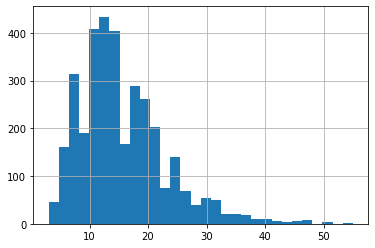

In [8]:
#get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [9]:
MAX_LENGTH = 12

In [11]:
#tokenize and ecode in train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGTH,
    padding = True,
    truncation = True
)

In [12]:
#tokenize and ecode in validation set
tokens_val= tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGTH,
    padding = True,
    truncation = True
)

In [13]:
#tokenize and ecode in test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGTH,
    padding = True,
    truncation = True
)

### convert lists to tensors

In [14]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y= torch.tensor(train_label.tolist())

In [15]:
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y= torch.tensor(val_label.tolist())

In [16]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y= torch.tensor(test_label.tolist())

### data loader structer definition

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq,train_mask,train_y)  
train_sampler = RandomSampler(train_data)                 
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

val_data = TensorDataset(val_seq,val_mask,val_y)  
val_sampler = RandomSampler(val_data)                 
val_dataloader = DataLoader(val_data,sampler=val_sampler,batch_size=batch_size)

## freeze layers

In [18]:
for param in bert.parameters():
  param.requires_grad = False

## define model architect

In [30]:
class BERT_Arch(nn.Module):
  def __init__(self,bert):
    super(BERT_Arch,self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768,512)
    self.fc2 = nn.Linear(512,2)
    self.softmax = nn.LogSoftmax(dim=1)
  def forward(self,sent_id,mask):
    cls_hs = self.bert(sent_id, attention_mask = mask)['pooler_output']
    x = self.fc1(cls_hs)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.softmax(x)
    return x

model = BERT_Arch(bert)

In [31]:
import torch
from torch.optim  import AdamW

optimizer = AdamW(model.parameters(),lr=1e-5)
cross_entropy = nn.NLLLoss()
epochs = 5

## define train & evaluate function

In [23]:
def train():
  model.train()
  total_loss, total_accuracy = 0,0

  for step,batch in enumerate(train_dataloader):
    if step%50 == 0 and not step == 0:
      print('  Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id,mask,labels = batch
    model.zero_grad()
    preds = model(sent_id,mask)
    loss = cross_entropy(preds,labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
    optimizer.step()
    preds = preds.detach().cpu().numpy()
  
  avg_loss = total_loss / len(train_dataloader)
  return avg_loss

In [24]:
def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0,0
  for step,batch in enumerate(val_dataloader):
    if step%50 == 0 and not step == 0:
      print('  Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))
    batch = [t for t in batch]
    sent_id,mask,labels = batch
    with torch.no_grad():
      preds = model(sent_id,mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

## model training

In [32]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

In [33]:
for epoch in range(epochs):
  print('\n Epoch {:} / {:}'.format(epoch+1,epochs))
  train_loss = train()
  valid_loss = evaluate()
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),'c1_new_model_weights.pt')
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\n Training loss: {train_loss:.3f}')
  print(f'\n Validation loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50 of   107.
  Batch   100 of   107.

Evaluating...

 Training loss: 0.681

 Validation loss: 0.676

 Epoch 2 / 5
  Batch    50 of   107.
  Batch   100 of   107.

Evaluating...

 Training loss: 0.677

 Validation loss: 0.676

 Epoch 3 / 5
  Batch    50 of   107.
  Batch   100 of   107.

Evaluating...

 Training loss: 0.676

 Validation loss: 0.675

 Epoch 4 / 5
  Batch    50 of   107.
  Batch   100 of   107.

Evaluating...

 Training loss: 0.677

 Validation loss: 0.675

 Epoch 5 / 5
  Batch    50 of   107.
  Batch   100 of   107.

Evaluating...

 Training loss: 0.676

 Validation loss: 0.674


## model perfomance

In [34]:
with torch.no_grad():
  preds = model(test_seq,test_mask)
  preds = preds.detach().cpu().numpy()

In [35]:
preds = np.argmax(preds,axis=1)
print(classification_report(test_y,preds))

              precision    recall  f1-score   support

           0       0.48      0.03      0.06       425
           1       0.59      0.98      0.73       602

    accuracy                           0.59      1027
   macro avg       0.53      0.50      0.40      1027
weighted avg       0.54      0.59      0.45      1027



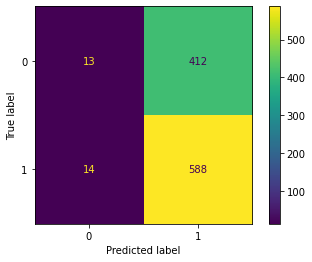

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_y,preds)
# plt.tick_params(axis=u'both', which=u'both',length=0)
# plt.grid(b=None)
plt.show()

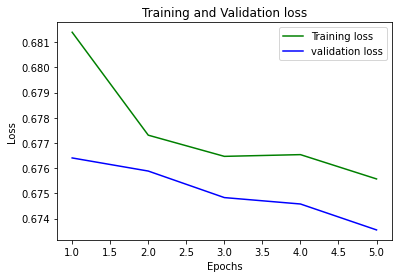

In [39]:
epochs = range(1,6)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

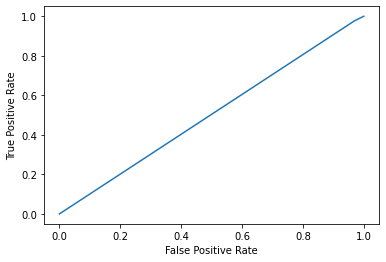

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(test_y, preds)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# fake news predict

In [41]:
unseen_news_text = [
    "Україна вдарила ракетами по ГЕС в Каховці"
]

In [42]:
MAX_LENGTH = 6
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGTH,
    pad_to_max_length = True,
    truncation = True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

c:\Users\Admin\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [46]:
with torch.no_grad():
  preds = model(unseen_seq,unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds,axis=1)
for i in preds:
  if preds == 1 :
    print(i,"Fake")
  else:
    print(i, "True")

1 Fake
